Installing Neccessary Library - catboost/xgboost

In [1]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Importing Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, RepeatedKFold, validation_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

Adding Custom Transformer same as previous EDA

In [4]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.features]

Load and Preprocess the Dataset

In [5]:
df = pd.read_excel("C:\\Users\\singh\\House-Price-Pediction\\HousePricePrediction\\HousePricePrediction.xlsx")
df.drop('Id', axis=1, inplace=True)
df = df.dropna(subset=['SalePrice'])

In [6]:
y = np.log1p(df['SalePrice'])
df = df.drop('SalePrice', axis=1)

num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

Performing Pipelining Processing

In [7]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_features)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

X_prepared = full_pipeline.fit_transform(df)
onehot_encoder = full_pipeline.transformer_list[1][1].named_steps['onehot']
feature_names = num_features + list(onehot_encoder.get_feature_names_out(cat_features))
X_df = pd.DataFrame(X_prepared, columns=feature_names)

def remove_by_vif(X, thresh=5.0):
    while True:
        vif = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )
        max_vif = vif.max()
        if max_vif > thresh:
            drop_col = vif.idxmax()
            print(f"Removing '{drop_col}' due to high VIF: {max_vif:.2f}")
            X = X.drop(columns=[drop_col])
        else:
            break
    return X

def remove_by_pvalue(X, y, thresh=0.05):
    while True:
        X_const = sm.add_constant(X)
        y_aligned = y.loc[X.index]
        model = sm.OLS(y_aligned, X_const).fit()
        pvalues = model.pvalues.iloc[1:]
        max_pval = pvalues.max()
        if max_pval > thresh:
            drop_col = pvalues.idxmax()
            print(f"Removing '{drop_col}' due to high p-value: {max_pval:.4f}")
            X = X.drop(columns=[drop_col])
        else:
            break
    return X

In [8]:
X_df_clean = remove_by_vif(X_df.copy())
X_df_final = remove_by_pvalue(X_df_clean.copy(), y)


c:\Users\singh\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing 'MSZoning_C (all)' due to high VIF: inf


c:\Users\singh\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing 'LotConfig_Corner' due to high VIF: inf


c:\Users\singh\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing 'BldgType_1Fam' due to high VIF: inf
Removing 'Exterior1st_VinylSd' due to high VIF: 57.09
Removing 'MSZoning_RL' due to high VIF: 7.46
Removing 'MSZoning_RH' due to high p-value: 0.8785
Removing 'LotConfig_FR3' due to high p-value: 0.8091
Removing 'Exterior1st_MetalSd' due to high p-value: 0.8059
Removing 'Exterior1st_CBlock' due to high p-value: 0.7691
Removing 'Exterior1st_WdShing' due to high p-value: 0.5309
Removing 'Exterior1st_AsphShn' due to high p-value: 0.5227
Removing 'Exterior1st_ImStucc' due to high p-value: 0.4998
Removing 'Exterior1st_Plywood' due to high p-value: 0.4538
Removing 'LotConfig_CulDSac' due to high p-value: 0.3888
Removing 'Exterior1st_AsbShng' due to high p-value: 0.3404
Removing 'Exterior1st_CemntBd' due to high p-value: 0.2967
Removing 'LotConfig_FR2' due to high p-value: 0.2353
Removing 'MSZoning_FV' due to high p-value: 0.1888
Removing 'Exterior1st_Wd Sdng' due to high p-value: 0.1793
Removing 'Exterior1st_Stucco' due to high p-value: 0.2350
Re

Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
X_df_final, y, test_size=0.2, random_state=42)

Validation Curves And Plotting

In [10]:
def plot_validation_curve(estimator, X, y, param_name, param_range, title):
    train_scores, test_scores = validation_curve(
        estimator=estimator,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(param_range, train_mean, label="Training Score", color="darkorange", lw=2)
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
    plt.plot(param_range, test_mean, label="Testing Score", color="navy", lw=2)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="navy")
    plt.xlabel(param_name)
    plt.ylabel("R2 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

Linear Regression

In [11]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
lr_pipe.fit(X_train, y_train)
y_pred_lr = lr_pipe.predict(X_test)
print(f"Linear Regression R2: {r2_score(y_test, y_pred_lr):.6f}")

Linear Regression R2: 0.703165


Ridge Regression

In [12]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
ridge_params = {'ridge__alpha': [0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_cv.fit(X_train, y_train)
print(f"Best Ridge Alpha: {ridge_cv.best_params_}")
print(f"Ridge Regression R2 (CV): {ridge_cv.best_score_:.6f}")


Best Ridge Alpha: {'ridge__alpha': 1}
Ridge Regression R2 (CV): 0.668362


Ridge alpha validation curve

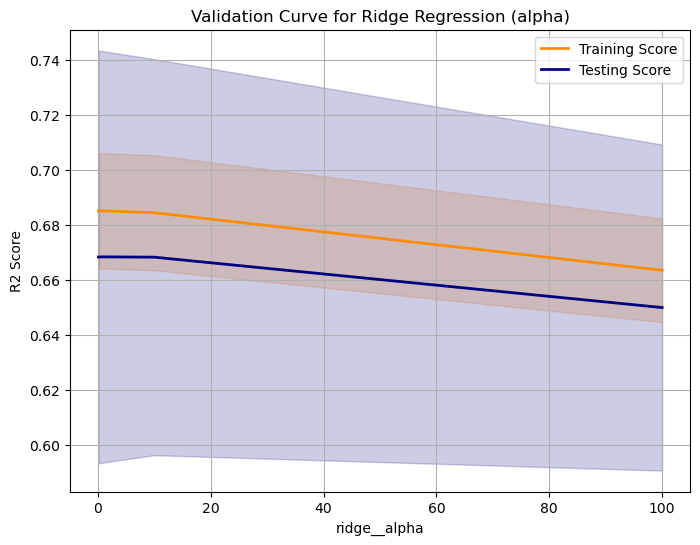

In [13]:
plot_validation_curve(
    estimator=ridge_pipe,
    X=X_train,
    y=y_train,
    param_name='ridge__alpha',
    param_range=[0.1, 1, 10, 100],
    title='Validation Curve for Ridge Regression (alpha)'
)

SVR

In [14]:
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
svr_params = {
    'svr__kernel': ['rbf'],
    'svr__C': [1, 10, 100],
    'svr__gamma': ['scale', 0.01],
    'svr__epsilon': [0.1, 0.2]
}
svr_cv = GridSearchCV(svr_pipe, svr_params, cv=5, scoring='r2', n_jobs=-1)
svr_cv.fit(X_train, y_train)
print(f"Best SVR Params: {svr_cv.best_params_}")
print(f"SVR R2 (CV): {svr_cv.best_score_:.6f}")

Best SVR Params: {'svr__C': 1, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
SVR R2 (CV): 0.782395


SVR validation curve

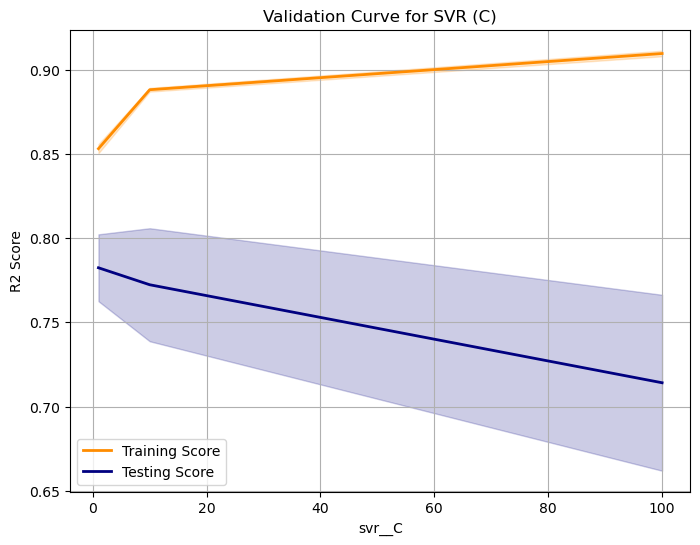

In [15]:
plot_validation_curve(
    estimator=svr_pipe,
    X=X_train,
    y=y_train,
    param_name='svr__C',
    param_range=[1, 10, 100],
    title='Validation Curve for SVR (C)'
)

Gradient Boosting Regression

In [16]:
gbr_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gbr_cv = GridSearchCV(GradientBoostingRegressor(random_state=42),
                      gbr_params, cv=5, scoring='r2', n_jobs=-1)
gbr_cv.fit(X_train, y_train)
print(f"Best GBR Params: {gbr_cv.best_params_}")
print(f"Gradient Boosting R2 (CV): {gbr_cv.best_score_:.6f}")

Best GBR Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Gradient Boosting R2 (CV): 0.808804


Gradient Boosting learning rate validation curve

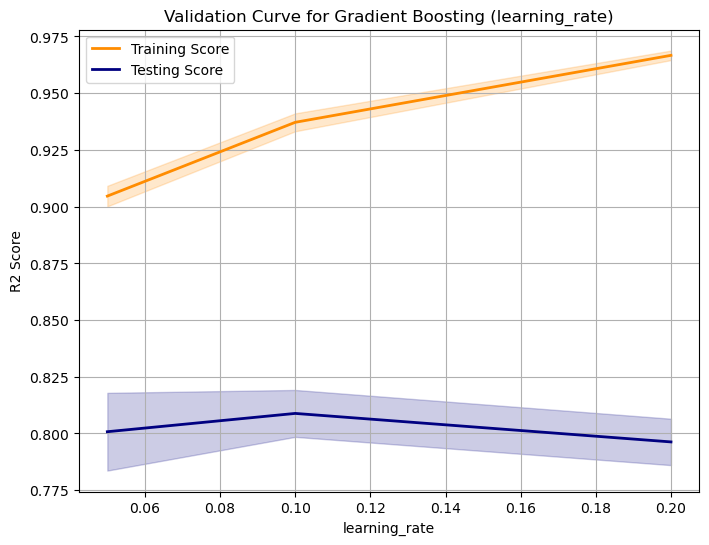

In [17]:
plot_validation_curve(
    estimator=GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=3),
    X=X_train,
    y=y_train,
    param_name='learning_rate',
    param_range=[0.05, 0.1, 0.2],
    title='Validation Curve for Gradient Boosting (learning_rate)'
)